In [1]:
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from scipy import stats

### Global Variables, OHLC Data, Calculate 'Simple/Objective' Indicators

In [2]:
candle_time_interval = 5 
portfolio_value = 100000
position_size = 10000
fees_and_slippage = 0.001

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

In [3]:
btc_usdt_df = pd.read_csv('data/BTCUSDT.csv')
eth_usdt_df = pd.read_csv('data/ETHUSDT.csv')

dataframes = [btc_usdt_df, eth_usdt_df]

for df in dataframes:
    df.columns = map(str.lower, df.columns)
    df.drop(['close time', 'volume', 'taker buy base', 'taker buy quote', 'ignore'], axis=1, inplace=True)
    df.rename(columns={'quote asset volume': 'volume_usd', 'number of trades': 'num_trades', 'open time': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['sma50'] = ta.trend.sma_indicator(df['close'], window=50)
    df['sma100'] = ta.trend.sma_indicator(df['close'], window=100)
    df['sma200'] = ta.trend.sma_indicator(df['close'], window=200)
    df['date'] = df['time'].dt.date
    df['vwap'] = df.groupby('date').apply(lambda x: (x['close'] * x['volume_usd']).cumsum() / x['volume_usd'].cumsum()).reset_index(level=0, drop=True)
    df.drop('date', axis=1, inplace=True)
    df['hlc_3'] = (df['high'] + df['low'] + df['close'])/3
    df['dist_to_sma50'] = df['hlc_3'] - df['sma50']
    df['dist_to_sma100'] = df['hlc_3'] - df['sma100']
    df['dist_to_sma200'] = df['hlc_3'] - df['sma200']
    df['dist_to_vwap'] = df['hlc_3'] - df['vwap']
    df[['atr', 'rsi', 'sma50', 'sma100','sma200']] = df[['atr', 'rsi', 'sma50', 'sma100','sma200']].round(2)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
# Don't want to use whole 250k rows while testing code.
btc_usdt_df = btc_usdt_df.head(20000)
btc_usdt_df.head()

,time,open,high,low,close,volume_usd,num_trades,atr,rsi,sma50,sma100,sma200,vwap,hlc_3,dist_to_sma50,dist_to_sma100,dist_to_sma200,dist_to_vwap
0,2020-12-17 06:10:00,22132.26,22133.35,22053.00,22089.95,9.270872e+06,6276,87.82,58.28,21907.20,21660.13,21168.37,21807.137986,22092.100000,184.899400,431.969300,923.731900,284.962014
1,2020-12-17 06:15:00,22089.95,22136.59,22063.81,22133.99,5.376863e+06,4869,86.74,60.88,21915.80,21669.54,21179.80,21809.427128,22111.463333,195.659133,441.920533,931.659383,302.036206
2,2020-12-17 06:20:00,22134.00,22230.00,22113.00,22230.00,1.160161e+07,7891,88.90,65.88,21924.50,21678.81,21189.80,21815.688049,22191.000000,266.502200,512.186900,1001.197900,375.311951
3,2020-12-17 06:25:00,22229.99,22271.45,22190.00,22269.14,9.205871e+06,7432,88.37,67.70,21933.54,21688.38,21199.92,21820.981937,22243.530000,309.989200,555.152100,1043.610350,422.548063
4,2020-12-17 06:30:00,22269.15,22400.00,22099.55,22111.57,3.789862e+07,17642,103.52,55.02,21938.49,21696.47,21208.82,21834.307722,22203.706667,265.212267,507.237767,994.883867,369.398945


### Define & Calculate 'Complex/Subjective' Indicators (Ex: Horizontal Lines)

In [4]:
def find_horizontal_resistance_lines_and_touch_points(df):
    resistance_lines = []
    i = 0
    waiting_period = 10

    while i < len(df) - waiting_period: 
        origin_candle = df.iloc[i]

        if origin_candle['close'] > origin_candle['open']:
            line_price = 0.6 * origin_candle['close'] + 0.4 * origin_candle['high'] 
            touch_points = {}
            touch_prices = {}
            last_touch_point_index = i

            waiting_candles = df.iloc[i+1:i+waiting_period+1]
            waiting_candles_upper_range = line_price + (0.5 * waiting_candles['atr'])
            waiting_candles_line_price = 0.6 * waiting_candles[['close', 'open']].max(axis=1) + 0.4 * waiting_candles['high']
            
            if any(waiting_candles_line_price > waiting_candles_upper_range):
                i += 1
                continue

            for j in range(i+waiting_period, len(df)):  
                candle = df.iloc[j]
                upper_range = line_price + (0.5 * candle['atr'])
                lower_range = line_price - (0.5 * candle['atr'])
                bottom_limit = line_price - (5 * candle['atr'])
                candle_line_price = 0.6 * candle[['close', 'open']].max() + 0.4 * candle['high']
                candle_line_price_bottom = 0.6 * candle[['close', 'open']].min() + 0.4 * candle['low']

                if j - last_touch_point_index >= waiting_period and lower_range <= candle_line_price <= upper_range:
                    touch_points[f'touch_point_{len(touch_points)+2}'] = candle['time']
                    touch_prices[f'touch_point_{len(touch_prices)+2}_price'] = candle_line_price
                    last_touch_point_index = j

                if candle_line_price > upper_range or candle_line_price_bottom < bottom_limit:
                    if len(touch_points) > 0:
                        line = {'initial_point': origin_candle['time'], 'end_of_line': candle['time'], 'line_price': line_price}
                        line.update(touch_points)
                        line.update(touch_prices)
                        resistance_lines.append(line)
                    i = j + 1
                    break
            else:
                i += 1
        else:
            i += 1

    return pd.DataFrame(resistance_lines)

resistance_lines_df = find_horizontal_resistance_lines_and_touch_points(btc_usdt_df)

# Add & Sort columns
resistance_lines_df['line_length'] = (resistance_lines_df['end_of_line'] - resistance_lines_df['initial_point']).dt.total_seconds() / (candle_time_interval * 60)
resistance_lines_df['line_length'] = resistance_lines_df['line_length'].astype(int)
resistance_lines_df['num_touch_points'] = resistance_lines_df.filter(regex='touch_point_\d+$').count(axis=1) + 1

static_columns = ['initial_point', 'end_of_line', 'line_length', 'line_price', 'num_touch_points']
touch_point_columns = [col for col in resistance_lines_df.columns if 'touch_point' in col and col != 'num_touch_points']
touch_point_columns.sort(key=lambda x: int(x.split('_')[-2]) if x.split('_')[-1] == 'price' else int(x.split('_')[-1]))
ordered_columns = static_columns + touch_point_columns
resistance_lines_df = resistance_lines_df[ordered_columns]
resistance_lines_df.head(10)

,initial_point,end_of_line,line_length,line_price,num_touch_points,touch_point_2,touch_point_2_price,touch_point_3,touch_point_3_price,touch_point_4,touch_point_4_price,touch_point_5,touch_point_5_price,touch_point_6,touch_point_6_price,touch_point_7,touch_point_7_price
0,2020-12-17 06:25:00,2020-12-17 07:20:00,11,22270.064,2,2020-12-17 07:15:00,22288.760,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,2020-12-17 09:25:00,2020-12-17 13:05:00,44,23162.428,2,2020-12-17 12:55:00,23169.594,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
2,2020-12-17 13:35:00,2020-12-17 16:05:00,30,23326.852,2,2020-12-17 15:50:00,23270.470,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
3,2020-12-17 16:30:00,2020-12-17 18:15:00,21,23642.482,2,2020-12-17 17:20:00,23587.012,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
4,2020-12-17 20:50:00,2020-12-17 22:00:00,14,22721.138,2,2020-12-17 21:40:00,22696.168,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
5,2020-12-17 22:45:00,2020-12-18 02:15:00,42,23044.328,3,2020-12-18 01:15:00,22996.666,2020-12-18 02:05:00,23065.744,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
6,2020-12-18 05:05:00,2020-12-18 06:05:00,12,23006.120,2,2020-12-18 06:00:00,22977.098,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
7,2020-12-18 14:00:00,2020-12-18 16:50:00,34,22690.784,2,2020-12-18 16:35:00,22687.952,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
8,2020-12-18 17:45:00,2020-12-18 21:00:00,39,22800.496,3,2020-12-18 18:45:00,22774.192,2020-12-18 20:00:00,22776.656,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9,2020-12-18 21:25:00,2020-12-18 23:50:00,29,23063.728,2,2020-12-18 23:45:00,23056.972,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


### Define Trading Strategy

In [5]:
def trading_strategy(df, resistance_lines_df):

    trades_df = pd.DataFrame(columns=['result', 'entry_price', 'sl_main', 'tp1', 'tp2', 'tp3', 'tsl1', 'tsl2', 'entry_time', 'sl_main_time', 'tp1_time',  'tp2_time', 'tp3_time', 'tsl1_time', 'tsl2_time'])

    for idx, row in resistance_lines_df.iterrows():
        if row['num_touch_points'] < 3:
            continue
        
        third_point = row['touch_point_3']
        third_point_index = df[df['time'] == third_point].index[0]
        
        rsi = df.iloc[third_point_index]['rsi']
        dist_to_vwap = df.iloc[third_point_index]['dist_to_vwap']
        if rsi < 50 or dist_to_vwap <= 0:
            continue

        entry_price = df.iloc[third_point_index + 1]['open']
        entry_time = df.iloc[third_point_index + 1]['time']
        slice_df = df.iloc[third_point_index + 1:]

        result = 'None'
        sl_main_time = pd.NaT 
        tp1_time = pd.NaT
        tp2_time = pd.NaT
        tp3_time = pd.NaT
        tsl1_time = pd.NaT
        tsl2_time = pd.NaT

        for _, candle in slice_df.iterrows():
            atr = candle['atr']
            sl_main = entry_price - 1.3 * atr
            tp1 = entry_price + 2 * atr
            tp2 = entry_price + 3 * atr
            tp3 = entry_price + 4 * atr
            tsl1 = entry_price
            tsl2 = tp1

            if candle['low'] <= sl_main and result == 'None':
                result = 'sl_main_hit'
                sl_main_time = candle['time']
                break
            elif candle['high'] >= tp1 and result == 'None':
                result = 'tp1_hit_then_tsl1'
                tp1_time = candle['time']
            elif candle['low'] <= tsl1 and result == 'tp1_hit_then_tsl1':
                tsl1_time = candle['time']
                break
            elif candle['high'] >= tp2 and result == 'tp1_hit_then_tsl1':
                result = 'tp2_hit_then_tsl2'
                tp2_time = candle['time']
            elif candle['low'] <= tsl2 and result == 'tp2_hit_then_tsl2':
                tsl2_time = candle['time']
                break
            elif candle['high'] >= tp3 and result == 'tp2_hit_then_tsl2':
                result = 'tp3_hit'
                tp3_time = candle['time']
                break

        new_row = pd.DataFrame({'result': [result], 'entry_price': [entry_price], 'sl_main': [sl_main], 'tp1': [tp1], 'tp2': [tp2], 'tp3': [tp3], 'tsl1': [tsl1], 'tsl2': [tsl2], 'entry_time': [entry_time], 'sl_main_time': [sl_main_time], 'tp1_time': [tp1_time], 'tp2_time': [tp2_time], 'tp3_time': [tp3_time], 'tsl1_time': [tsl1_time], 'tsl2_time': [tsl2_time]
        })
        trades_df = pd.concat([trades_df, new_row], ignore_index=True)

    return trades_df

trades_df = trading_strategy(btc_usdt_df, resistance_lines_df)


# Add & Sort columns
trades_df['pos_size'] = position_size
trades_df['fee'] = fees_and_slippage * trades_df['pos_size']

result_to_time_col = {'sl_main_hit': 'sl_main_time', 'tp1_hit_then_tsl1': 'tsl1_time', 'tp2_hit_then_tsl2': 'tsl2_time', 'tp3_hit': 'tp3_time'}
trades_df['exit_time'] = trades_df.apply(lambda row: row[result_to_time_col[row['result']]], axis=1)
trades_df['trade_length_minutes'] = (trades_df['exit_time'] - trades_df['entry_time']).dt.total_seconds() / 60
trades_df['trade_length_candles'] = (trades_df['trade_length_minutes'] / candle_time_interval).astype(int)

result_to_exit_info = {
    'sl_main_hit': [('sl_main', 1.0)],
    'tp1_hit_then_tsl1': [('tp1', 0.5), ('tsl1', 0.5)],
    'tp2_hit_then_tsl2': [('tp1', 0.5), ('tp2', 0.25), ('tsl2', 0.25)],
    'tp3_hit': [('tp1', 0.5), ('tp2', 0.25), ('tp3', 0.25)]
}

result_to_exit_price_col = {'sl_main_hit': 'sl_main', 'tp1_hit_then_tsl1': 'tsl1', 'tp2_hit_then_tsl2': 'tsl2', 'tp3_hit': 'tp3'}
trades_df['exit_price'] = trades_df.apply(lambda row: row[result_to_exit_price_col[row['result']]], axis=1)

def calculate_pl_b4_fee(row):
    pl_b4_fee = 0
    for exit_info in result_to_exit_info[row['result']]:
        exit_price_col, percentage = exit_info
        exit_price = row[exit_price_col]
        pl_b4_fee += (exit_price - row['entry_price']) * (row['pos_size'] * percentage / row['entry_price'])
    return pl_b4_fee

trades_df['pl_b4_fee'] = trades_df.apply(calculate_pl_b4_fee, axis=1)
trades_df['net_pl_with_fee'] = trades_df['pl_b4_fee'] - trades_df['fee']

sorted_columns = ['result', 'entry_price', 'exit_price', 'sl_main', 'tp1', 'tp2', 'tp3', 'tsl1', 'tsl2', 'entry_time', 'exit_time', 'sl_main_time', 'tp1_time', 'tp2_time', 'tp3_time', 'tsl1_time', 'tsl2_time', 'pos_size', 'pl_b4_fee', 'fee', 'net_pl_with_fee', 'trade_length_minutes', 'trade_length_candles']
trades_df = trades_df[sorted_columns]
trades_df.head()

,result,entry_price,exit_price,sl_main,tp1,tp2,tp3,tsl1,tsl2,entry_time,exit_time,sl_main_time,tp1_time,tp2_time,tp3_time,tsl1_time,tsl2_time,pos_size,pl_b4_fee,fee,net_pl_with_fee,trade_length_minutes,trade_length_candles
0,sl_main_hit,23064.57,22945.88,22945.880,23247.17,23338.47,23429.77,23064.57,23247.17,2020-12-18 02:10:00,2020-12-18 03:00:00,2020-12-18 03:00:00,NaT,NaT,NaT,NaT,NaT,10000,-51.459880,10.0,-61.459880,50.0,10
1,tp2_hit_then_tsl2,23046.75,23150.55,22979.280,23150.55,23202.45,23254.35,23046.75,23150.55,2020-12-19 02:00:00,2020-12-19 03:05:00,NaT,2020-12-19 02:40:00,2020-12-19 02:55:00,NaT,NaT,2020-12-19 03:05:00,10000,50.668749,10.0,40.668749,65.0,13
2,tp3_hit,23056.31,23356.47,22958.758,23206.39,23281.43,23356.47,23056.31,23206.39,2020-12-19 12:35:00,2020-12-19 14:05:00,NaT,2020-12-19 13:50:00,2020-12-19 14:00:00,2020-12-19 14:05:00,NaT,NaT,10000,89.502613,10.0,79.502613,90.0,18
3,tp2_hit_then_tsl2,23583.40,23742.50,23479.985,23742.50,23822.05,23901.60,23583.40,23742.50,2020-12-20 15:10:00,2020-12-20 16:15:00,NaT,2020-12-20 15:30:00,2020-12-20 15:45:00,NaT,NaT,2020-12-20 16:15:00,10000,75.895545,10.0,65.895545,65.0,13
4,tp1_hit_then_tsl1,23889.99,23889.99,23808.844,24014.83,24077.25,24139.67,23889.99,24014.83,2020-12-20 19:45:00,2020-12-20 20:05:00,NaT,2020-12-20 20:00:00,NaT,NaT,2020-12-20 20:05:00,NaT,10000,26.128098,10.0,16.128098,20.0,4


### Analyze Trading Strategy

##### 1. Candlestick Chart with Trades

In [6]:
# Slices 'btc_usdt_df' into useable size, masks corresponding times for horizontal lines and trade information. Plotly crashes if head is set too high (20k+)
plt_btc_usdt_df = btc_usdt_df.head(6000)
last_timestamp = plt_btc_usdt_df['time'].iloc[-1]

mask = resistance_lines_df['end_of_line'] <= last_timestamp
mask_two = trades_df['exit_time'] <= last_timestamp
plt_resistance_lines_df = resistance_lines_df[mask]
plt_trades_df = trades_df[mask_two]

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adds Candlesticks, line origin, line end to graph.
candlesticks = go.Candlestick(x=plt_btc_usdt_df['time'], open=plt_btc_usdt_df['open'], high=plt_btc_usdt_df['high'], low=plt_btc_usdt_df['low'], close=plt_btc_usdt_df['close'], name='Candlesticks')
line_origin = go.Scatter(x=plt_resistance_lines_df['initial_point'], y=plt_resistance_lines_df['line_price'], mode='markers', name='Line Origin', marker=dict(color='#FFD700', size=7))
line_end = go.Scatter(x=plt_resistance_lines_df['end_of_line'], y=plt_resistance_lines_df['line_price'], mode='markers', name='Line End', marker=dict(color='#FFD700', size=7))

# Adds the horizontal resistance lines to graph.
for _, row in plt_resistance_lines_df.iterrows():
    start_time = row['initial_point']
    end_time = row['end_of_line']
    price = row['line_price']
    fig.add_shape(type="line", x0=start_time, y0=price, x1=end_time, y1=price, line=dict(color='#FFD700', width=2), xref='x', yref='y')

# Adds entries and ATR to graph.
entries = go.Scatter(x=plt_trades_df['entry_time'], y=plt_trades_df['entry_price'], mode='markers', name='Entry', marker=dict(color='#39FF14', size=7))
atr = go.Scatter(x=plt_btc_usdt_df['time'], y=plt_btc_usdt_df['atr'], mode='lines', name='ATR', line=dict(color='#FC0FC0'), opacity=0.2)

fig.add_trace(candlesticks, secondary_y=False)
fig.add_trace(line_origin, secondary_y=False)
fig.add_trace(line_end, secondary_y=False)

# Adds all the touch points starting with 'touch_point_2'
for i in range(2, len(plt_resistance_lines_df.columns)):
    touch_point_column = 'touch_point_' + str(i)
    touch_price_column = 'touch_point_' + str(i) + '_price'

    if touch_point_column in plt_resistance_lines_df.columns:
        touch_points = go.Scatter(x=plt_resistance_lines_df[touch_point_column], y=plt_resistance_lines_df[touch_price_column], mode='markers', name=f'Touch Point {i}', marker=dict(color='#00FFEF', size=7))
        fig.add_trace(touch_points, secondary_y=False)

fig.add_trace(entries, secondary_y=False)

# Adds all the exit points
exit_points = ['tp1', 'tp2', 'tp3', 'sl_main', 'tsl1', 'tsl2']
colors = ['#39FF14', '#39FF14', '#39FF14', 'red', 'red', 'red']

for exit_point, color in zip(exit_points, colors):
    exit_time_col = exit_point + '_time'
    mask = plt_trades_df[exit_time_col].notna()
    exits = go.Scatter(
        x=plt_trades_df.loc[mask, exit_time_col], 
        y=plt_trades_df.loc[mask, exit_point], 
        mode='markers', 
        name=f'{exit_point} Exit', 
        marker=dict(color=color, size=7)
    )
    fig.add_trace(exits, secondary_y=False)
    
fig.add_trace(atr, secondary_y=True)

fig.update_layout(title='BTC/USDT', xaxis_title='Time', template="plotly_dark", legend=dict(y=1.2, font=dict(size=12)))
fig.update_yaxes(title_text='Price', secondary_y=False, tickformat="$,.2f", autorange=True, fixedrange=False)
fig.update_yaxes(title_text='ATR', secondary_y=True)

fig.show()

##### 2. Trade Stats Calculations

In [41]:
# Trade Basics
num_sl_main = trades_df['result'].value_counts().get('sl_main_hit', 0)
num_tsl1 = trades_df['result'].value_counts().get('tp1_hit_then_tsl1', 0)
num_tsl2 = trades_df['result'].value_counts().get('tp2_hit_then_tsl2', 0)
num_tp3 = trades_df['result'].value_counts().get('tp3_hit', 0)
num_wins = num_tsl1 + num_tsl2 + num_tp3
num_losses = num_sl_main
total_trades = trades_df['result'].count()

win_pct = num_wins / total_trades
loss_pct = num_losses / total_trades

total_winners_profit = trades_df.loc[trades_df['net_pl_with_fee'] > 0, 'net_pl_with_fee'].sum()
total_losers_loss = abs(trades_df.loc[trades_df['net_pl_with_fee'] < 0, 'net_pl_with_fee'].sum())

avg_profit_per_winner = total_winners_profit / num_wins
avg_loss_per_loser = total_losers_loss / num_losses
R = avg_profit_per_winner / avg_loss_per_loser

# Timing, Trade PNL & %
total_trade_length = trades_df['trade_length_minutes'].sum()
total_time = (btc_usdt_df['time'].max() - btc_usdt_df['time'].min()).total_seconds() / 60
exposure = total_trade_length / total_time

avg_trade_pl = trades_df['net_pl_with_fee'].mean()
max_trade_pl = trades_df['net_pl_with_fee'].max()
min_trade_pl = trades_df['net_pl_with_fee'].min()

# Cumulative Portfolio Value and Running Max (Running ATH portfolio value)
trades_df['cum_port_value'] = trades_df['net_pl_with_fee'].cumsum() + portfolio_value
trades_df.loc[0, 'running_max'] = portfolio_value

for i in range(1, len(trades_df)):
    if trades_df.loc[i, 'cum_port_value'] > trades_df.loc[i-1, 'running_max']:
        trades_df.loc[i, 'running_max'] = trades_df.loc[i, 'cum_port_value']
    else:
        trades_df.loc[i, 'running_max'] = trades_df.loc[i-1, 'running_max']

equity_final = trades_df['cum_port_value'].iloc[-1]

# Drawdown Calculations
trades_df['drawdown'] = trades_df['cum_port_value'] - trades_df['running_max']
trades_df['drawdown_pct'] = trades_df['drawdown'] / trades_df['running_max']

drawdown_periods = []

in_drawdown = False
start_index, start_time = None, None

# Check if the first row is a negative drawdown
if trades_df.loc[0, 'drawdown'] < 0:
    start_index = 0
    start_time = trades_df.loc[0, 'exit_time']
    in_drawdown = True

for i in range(1, len(trades_df)):
    current_drawdown = trades_df.loc[i, 'drawdown']

    if not in_drawdown and current_drawdown == 0 and trades_df.loc[i+1, 'drawdown'] < 0:
        # Drawdown starts
        start_index = i
        start_time = trades_df.loc[i, 'exit_time']
        in_drawdown = True
    elif in_drawdown and current_drawdown == 0:
        # Drawdown ends
        end_index = i
        end_time = trades_df.loc[i, 'exit_time']
        num_trades = end_index - start_index 
        time_to_recover = (end_time - start_time).total_seconds() / (60 * 60 * 24)

        # Get the maximum drawdown and drawdown_pct within the drawdown period
        peak_drawdown = trades_df.loc[start_index:end_index, 'drawdown'].min()
        peak_drawdown_pct = trades_df.loc[start_index:end_index, 'drawdown_pct'].min()
        drawdown_periods.append([start_index, end_index, num_trades, time_to_recover, peak_drawdown, peak_drawdown_pct])

        # Check if the current zero drawdown is also the start of the next drawdown
        if i+1 < len(trades_df) and trades_df.loc[i+1, 'drawdown'] < 0:
            start_index = i
            start_time = trades_df.loc[i, 'exit_time']
        else:
            # Reset status
            in_drawdown = False
            start_index, start_time = None, None

# Handle the case where drawdown is not recovered by the end
if in_drawdown:
    # Drawdown ends
    end_index = i
    end_time = trades_df.loc[end_index, 'exit_time']
    num_trades = end_index - start_index 
    time_to_recover = (end_time - start_time).total_seconds() / (60 * 60 * 24)

    # Get the maximum drawdown and drawdown_pct within the drawdown period
    peak_drawdown = trades_df.loc[start_index:end_index, 'drawdown'].min()
    peak_drawdown_pct = trades_df.loc[start_index:end_index, 'drawdown_pct'].min()
    drawdown_periods.append([start_index, end_index, num_trades, time_to_recover, peak_drawdown, peak_drawdown_pct])

# Convert the list of drawdown periods to a DataFrame
drawdown_periods_df = pd.DataFrame(drawdown_periods, columns=['start_index', 'end_index', 'num_trades_in_dd', 'days_in_dd', 'peak_dd', 'peak_dd_pct'])

avg_dd_days = drawdown_periods_df['days_in_dd'].mean()
avg_dd = drawdown_periods_df['peak_dd'].mean()
avg_dd_pct = drawdown_periods_df['peak_dd_pct'].mean()
longest_dd_days = drawdown_periods_df['days_in_dd'].max()
largest_dd = drawdown_periods_df['peak_dd'].min()
largest_dd_pct = drawdown_periods_df['peak_dd_pct'].min()

# copied df to sort by 'exit_time' to get daily values for various stats.
trades_df_copy = trades_df.copy()

trades_df_copy['exit_time'] = pd.to_datetime(trades_df_copy['exit_time'])
trades_df_copy.set_index('exit_time', inplace=True)
daily_values = trades_df_copy['cum_port_value'].resample('D').last()
daily_values.fillna(method='ffill', inplace=True)

first_return = (daily_values.iloc[0] / portfolio_value) - 1
daily_returns = daily_values.pct_change()
daily_returns.iloc[0] = first_return
up_days = daily_returns[daily_returns > 0]
down_days = daily_returns[daily_returns < 0]
daily_returns_max = daily_returns.max()
daily_returns_min = daily_returns.min()
daily_returns_avg = daily_returns.mean()
daily_returns_negative = daily_returns[daily_returns < 0]
downside_std = daily_returns_negative.std()
volatility = daily_returns.std()
sharpe_ratio = daily_returns_avg / volatility
sortino_ratio = daily_returns_avg / downside_std
kelly_pct = win_pct - (loss_pct / R)

trade_stats_df = pd.DataFrame({
    'equity_start': [portfolio_value],
    'equity_final': [equity_final],
    'max_port_value': trades_df['cum_port_value'].max(),
    'min_port_value': trades_df['cum_port_value'].min(),
    'pl total': trades_df['net_pl_with_fee'].sum(),
    'cumulative_returns_pct': (equity_final - portfolio_value)/(portfolio_value),
    'avg_pl_per_trade': trades_df['net_pl_with_fee'].mean(),
    'num_sl_main': [num_sl_main],
    'num_tsl1': [num_tsl1],
    'num_tsl2': [num_tsl2],
    'num_tp3': [num_tp3],
    'num_wins': [num_wins],
    'num_losses': [num_losses],
    'total_trades': [total_trades],
    'win_pct': [win_pct],
    'loss_pct': [loss_pct],
    'avg_trade_length': trades_df['trade_length_candles'].mean(),
    'max_trade_length': trades_df['trade_length_candles'].max(),
    'min_trade_length': trades_df['trade_length_candles'].min(),
    'exposure_time': [exposure],
    'avg_dd_days' : [avg_dd_days],
    'avg_dd': [avg_dd],
    'avg_dd_pct': [avg_dd_pct],
    'longest_dd_days' : [longest_dd_days],
    'largest_dd': [largest_dd],
    'largest_dd_pct': [largest_dd_pct],
    'avg_trade_pl': [avg_trade_pl],
    'max_trade_pl': [max_trade_pl],
    'min_trade_pl': [min_trade_pl],
    'avg_trade_pl_pct': [avg_trade_pl / position_size],
    'max_trade_pl_pct': [max_trade_pl / position_size],
    'min_trade_pl_pct': [min_trade_pl / position_size],
    'avg_profit_per_winner': [avg_profit_per_winner],
    'avg_loss_per_loser': [avg_loss_per_loser],
    'experienced_RR': [R],
    'winning_days_pct': [up_days.count()/(up_days.count() + down_days.count())],
    'avg_up_day_pct': [up_days.mean()],
    'avg_down_day_pct': [down_days.mean()],
    'sortino': [sortino_ratio],
    'sharpe': [sharpe_ratio],
    'volatility': [volatility],
    'kelly_pct': [kelly_pct]
})

trade_stats_df
#trades_df.head()
#drawdown_periods_df.head()

,equity_start,equity_final,max_port_value,min_port_value,pl total,cumulative_returns_pct,avg_pl_per_trade,num_sl_main,num_tsl1,num_tsl2,num_tp3,num_wins,num_losses,total_trades,win_pct,loss_pct,avg_trade_length,max_trade_length,min_trade_length,exposure_time,avg_dd_days,avg_dd,avg_dd_pct,longest_dd_days,largest_dd,largest_dd_pct,avg_trade_pl,max_trade_pl,min_trade_pl,avg_trade_pl_pct,max_trade_pl_pct,min_trade_pl_pct,avg_profit_per_winner,avg_loss_per_loser,experienced_RR,winning_days_pct,avg_up_day_pct,avg_down_day_pct,sortino,sharpe,volatility,kelly_pct
0,100000,100514.133891,101080.084172,99938.54012,514.133891,0.005141,6.677064,40,4,18,15,37,40,77,0.480519,0.519481,8.168831,30,0,0.031331,8.882937,-188.390617,-0.001867,47.211806,-808.478869,-0.007998,6.677064,151.899288,-124.988423,0.000668,0.01519,-0.012499,83.737033,64.603408,1.296171,0.510638,0.000981,-0.0008,0.173245,0.088964,0.000839,0.079738


##### 3. Cumulative Portfolio Value Graph, Underwater Plot, Rolling Risk Metrics

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=trades_df.index, y=trades_df['cum_port_value'], mode='lines', name='Portfolio Value', line=dict(color='orange')))
fig.update_yaxes(tickformat=",.2f")
fig.update_layout(title='Cumulative Portfolio Value', xaxis_title='Trade Number', yaxis_title='Portfolio Value', showlegend=False, template="plotly_dark")
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=trades_df.index, y=trades_df['drawdown_pct'], mode='lines', fill='tozeroy', name='Drawdown', line=dict(color='orange')))
fig.update_yaxes(tickformat="%", range=[trades_df['drawdown_pct'].min()*1.1, 0])
fig.update_layout(title='Underwater Plot', xaxis_title='Trade Number', yaxis_title='Drawdown', template="plotly_dark")
fig.add_hline(y=avg_dd_pct, line_dash='dash', line=dict(color='#be03fd', width=2))
fig.show()

rolling_sharpe = (daily_returns.rolling(window=7).mean()) / (daily_returns.rolling(window=7).std())

fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_sharpe.index, y=rolling_sharpe.values, mode='lines', name='7-Day Rolling Sharpe Ratio', line=dict(color='orange')))
fig.add_hline(y=sharpe_ratio, line=dict(color='#be03fd', width=2, dash='dash'))
fig.update_layout(title='7-Day Rolling Sharpe Ratio', xaxis_title='Date', yaxis_title='Sharpe Ratio', showlegend=False, template="plotly_dark")
fig.show()
    
rolling_sortino = (daily_returns.rolling(window=7).mean()) / (daily_returns_negative.rolling(window=7).std())

fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_sortino.index, y=rolling_sortino.values, mode='lines', name='7-Day Rolling Sortino Ratio', line=dict(color='orange')))
fig.add_hline(y=sortino_ratio, line=dict(color='#be03fd', width=2, dash='dash'))
fig.update_layout(title='7-Day Rolling Sortino Ratio', xaxis_title='Date', yaxis_title='Sortino Ratio', showlegend=False, template="plotly_dark")
fig.show()


rolling_volatility = daily_returns.rolling(window=7).std()

fig = go.Figure()
fig.add_trace(go.Scatter(x=rolling_volatility.index, y=rolling_volatility.values, mode='lines', name='7-Day Rolling Volatility', line=dict(color='orange')))
fig.add_hline(y=volatility, line=dict(color='#be03fd', width=2, dash='dash'))
fig.update_layout(title='7-Day Rolling Volatility', xaxis_title='Date', yaxis_title='Volatility', showlegend=False, template="plotly_dark")
fig.show()

##### 4. Distribution of Daily Returns, Distribution of Randomly Sampled Trades

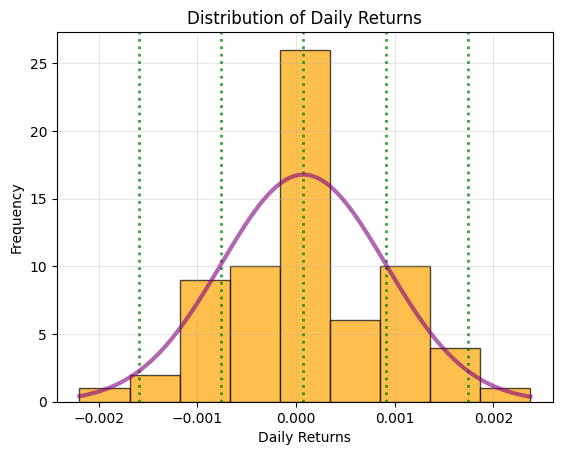

Mean: +0.01%
ONE std below and above the mean: (-0.08%, +0.09%)
TWO std below and above the mean: (-0.16%, +0.17%)


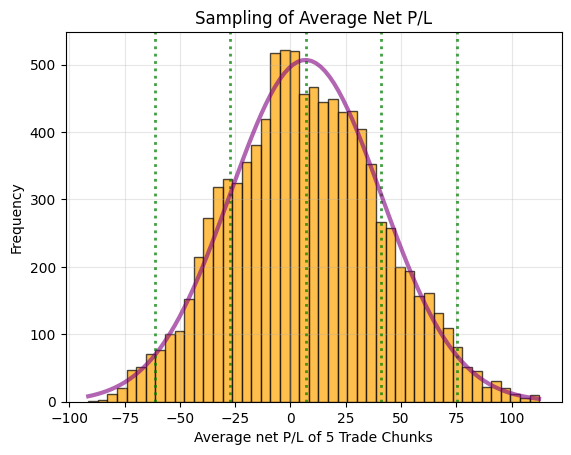

Mean: +$6.84
ONE std below and above the mean: (-$27.32, +$41.00)
TWO std below and above the mean: (-$61.48, +$75.16)


In [38]:
# Random pulling of trades for many iterations to get a smooth distribution of random trades.
sample_size=5
iterations=10000

def random_sample_avg_pl(trades_df, sample_size, iterations):
    all_pl = trades_df['net_pl_with_fee'].tolist()
    avg_pl_samples = []

    for _ in range(iterations):
        random_pl_sample = random.sample(all_pl, sample_size)
        avg_pl_samples.append(np.mean(random_pl_sample))
    return avg_pl_samples

avg_pl_samples = random_sample_avg_pl(trades_df, sample_size, iterations)

def plot_distribution(data, xlabel, ylabel, title, format_func):
    # Fit a Gaussian distribution
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(min(data), max(data), 100)

    # Probability Density Function, & calculates std's from the mean
    pdf = stats.norm.pdf(x, mu, sigma)
    one_std_left = mu - sigma
    one_std_right = mu + sigma
    two_std_left = mu - 2*sigma
    two_std_right = mu + 2*sigma

    # Plot vertical lines for the mean and std's
    plt.axvline(mu, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
    plt.axvline(one_std_left, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
    plt.axvline(one_std_right, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
    plt.axvline(two_std_left, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
    plt.axvline(two_std_right, color='green', linestyle='dotted', linewidth=2, alpha=0.75)

    # Plot the histogram & Rescale the Gaussian curve from probability density to the same frequency representation as the histogram
    n, bins, patches = plt.hist(data, bins='auto', color='orange', edgecolor='black', alpha=0.7)
    bin_width = bins[1] - bins[0]
    pdf_rescaled = pdf * len(data) * bin_width

    # Plot rescaled Gaussian curve
    plt.plot(x, pdf_rescaled, color='purple', alpha=0.6, linewidth=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Mean: {format_func(mu)}")
    print(f"ONE std below and above the mean: ({format_func(one_std_left)}, {format_func(one_std_right)})")
    print(f"TWO std below and above the mean: ({format_func(two_std_left)}, {format_func(two_std_right)})")

def format_1(value):
    return f"{'+' if value >= 0 else '-'}{'{:.2%}'.format(abs(value))}"

def format_2(value):
    return f"{'+' if value >= 0 else '-'}${'{:.2f}'.format(abs(value))}"

plot_distribution(daily_returns, 'Daily Returns', 'Frequency', 'Distribution of Daily Returns', format_1)
plot_distribution(avg_pl_samples, f'Average net P/L of {sample_size} Trade Chunks', 'Frequency', 'Sampling of Average Net P/L', format_2)

##### 5. Returns from Entry

In [39]:
def returns_from_entry(btc_usdt_df, trades_df):
    returns_dict = {}

    for idx, row in trades_df.iterrows():

        entry_price = row['entry_price']
        entry_time = row['entry_time']
        
        start_idx = btc_usdt_df.loc[btc_usdt_df['time'] == entry_time].index[0]
        end_idx = min(start_idx + 200, len(btc_usdt_df) - 1)
        slice_df = btc_usdt_df.iloc[start_idx:end_idx]

        returns_df = slice_df[['hlc_3']].copy()
        returns_df['returns'] = returns_df['hlc_3'].apply(lambda x: x - entry_price)

        returns_df.drop(columns=['hlc_3'], inplace=True)
        returns_df.reset_index(drop=True, inplace=True)
        returns_df.index = 'e+' + returns_df.index.astype(str)

        returns_dict[idx] = returns_df

    return returns_dict

returns_dict = returns_from_entry(btc_usdt_df, trades_df)

def create_returns_plot(analysis_dict):
    fig = go.Figure()

    for entry, returns_df in analysis_dict.items():
        returns_trace = go.Scatter(x=returns_df.index, y=returns_df['returns'], mode='lines', name=f'Trade {entry}', line=dict(color='orange'), opacity=0.3)
        fig.add_trace(returns_trace)

    fig.add_hline(y=0, line=dict(color='#be03fd', width=2, dash='dash'))

    fig.update_layout(title='Returns Over Time', xaxis_title="Candles after Entry", yaxis=dict(title='Returns', side='left', color='white'),
        showlegend=True,
        template="plotly_dark"
    )
    fig.show()

create_returns_plot(returns_dict)

max_returns = []
max_locations = []
min_returns = []
min_locations = []

for trade, returns_df in returns_dict.items():

    max_return = returns_df['returns'].max()
    max_location = returns_df['returns'].idxmax()
    min_return = returns_df['returns'].min()
    min_location = returns_df['returns'].idxmin()
    
    max_returns.append(max_return)
    max_locations.append(max_location)
    min_returns.append(min_return)
    min_locations.append(min_location)

max_locations = [int(location[2:]) for location in max_locations]
min_locations = [int(location[2:]) for location in min_locations]

overall_max_return = max(max_returns)
overall_min_return = min(min_returns)
e0_returns_sum = sum(returns_df.loc['e+0', 'returns'] for returns_df in returns_dict.values())

returns_stats_df = pd.DataFrame({
    'avg_max_return': [np.mean(max_returns)],
    'avg_min_return': [np.mean(min_returns)],
    'avg_max_return_location': [np.mean(max_locations)],
    'avg_min_return_location': [np.mean(min_locations)],
    'sum_max_returns': [np.sum(max_returns)],
    'sum_min_returns': [np.sum(min_returns)],
    'sum_min_max_returns': [np.sum(max_returns) + np.sum(min_returns)],
    'e0_returns_sum': [e0_returns_sum],
    'max_return': [overall_max_return],
    'min_return': [overall_min_return]
}).style.format('{:,.2f}').set_properties(**{'text-align': 'center'})

returns_stats_df

,avg_max_return,avg_min_return,avg_max_return_location,avg_min_return_location,sum_max_returns,sum_min_returns,sum_min_max_returns,e0_returns_sum,max_return,min_return
0,"1,328.98",-850.60,98.30,78.68,"102,331.29","-65,496.02","36,835.27","1,473.23","7,814.83","-5,152.97"
